In [6]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
import pickle

REBUILD_DATA = False

class DogsVsCats():
    IMG_SIZE = 50
    CATS = '.\kagglecatsanddogs_5340\PetImages\Cat'
    DOGS = '.\kagglecatsanddogs_5340\PetImages\Dog'
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for file_name in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, file_name)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        
        np.random.shuffle(self.training_data)

        with open("training_data.pkl", "wb") as f:
            pickle.dump(self.training_data, f)

        print('Cats:', self.catcount)
        print('Dogs:', self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

.\kagglecatsanddogs_5340\PetImages\Cat


100%|██████████| 12501/12501 [00:10<00:00, 1210.31it/s]


.\kagglecatsanddogs_5340\PetImages\Dog


100%|██████████| 12501/12501 [00:17<00:00, 727.71it/s] 


Cats: 12476
Dogs: 12470


In [8]:
training_data = np.load('training_data.pkl', allow_pickle=True)

In [9]:
print(len(training_data))

24946


In [10]:
print(training_data[0])

[array([[247, 247, 242, ..., 254, 253, 246],
       [246, 247, 249, ..., 254, 254, 251],
       [248, 249, 250, ..., 247, 236, 250],
       ...,
       [147, 155, 162, ..., 255, 245, 255],
       [145, 131, 146, ..., 255, 255, 244],
       [136, 140, 142, ..., 252, 253, 214]], dtype=uint8), array([0., 1.])]


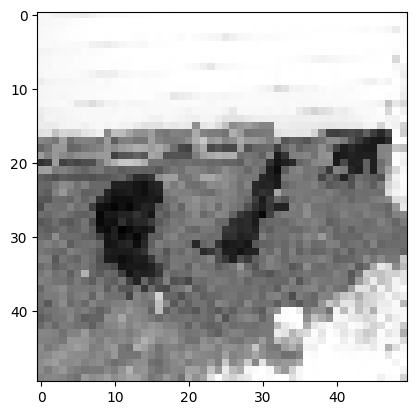

In [16]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5) 

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.flatten(start_dim=1)
        # print(x.shape) # printing the shape of the flattened output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

# net.forward(torch.randn(1, 1, 50, 50)) # passing a sample input (random)

In [33]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([x[0] for x in training_data]).view(-1, 50, 50)
X = X/255.0

y =torch.Tensor([x[1] for x in training_data])


VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [37]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [36]:
BATCH_SIZE = 100
EPOCHS = 1

def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

    print(loss)

train(net)



100%|██████████| 225/225 [00:38<00:00,  5.78it/s]

tensor(0.2424, grad_fn=<MseLossBackward0>)


In [40]:
correct = 0
total = 0

def test(net):
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print('Accuracy:', round(correct/total*100, 3))

test(net)

100%|██████████| 2494/2494 [00:03<00:00, 742.83it/s]

Accuracy: 54.09


In [41]:
torch.cuda.is_available()

True

In [42]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [44]:
torch.cuda.device_count()

1

In [43]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


In [45]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [48]:
net = Net().to(device)

In [56]:
EPOCHS = 10

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
            batch_y = train_y[i:i+BATCH_SIZE].to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch} - Loss {loss}')

train(net)

100%|██████████| 225/225 [00:02<00:00, 96.13it/s] 


Epoch 0 - Loss 0.0448099710047245


100%|██████████| 225/225 [00:02<00:00, 109.04it/s]


Epoch 1 - Loss 0.04185083135962486


100%|██████████| 225/225 [00:02<00:00, 103.26it/s]


Epoch 2 - Loss 0.038915909826755524


100%|██████████| 225/225 [00:02<00:00, 108.41it/s]


Epoch 3 - Loss 0.039420001208782196


100%|██████████| 225/225 [00:02<00:00, 108.21it/s]


Epoch 4 - Loss 0.024638328701257706


100%|██████████| 225/225 [00:02<00:00, 107.79it/s]


Epoch 5 - Loss 0.042650770395994186


100%|██████████| 225/225 [00:02<00:00, 108.37it/s]


Epoch 6 - Loss 0.022463858127593994


100%|██████████| 225/225 [00:02<00:00, 108.09it/s]


Epoch 7 - Loss 0.027814026921987534


100%|██████████| 225/225 [00:02<00:00, 108.04it/s]


Epoch 8 - Loss 0.022742385044693947


100%|██████████| 225/225 [00:02<00:00, 108.29it/s]

Epoch 9 - Loss 0.025898730382323265


In [57]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print('Accuracy:', round(correct/total*100, 3))

test(net)

100%|██████████| 2494/2494 [00:02<00:00, 1156.37it/s]

Accuracy: 76.383


In [65]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    acc = matches.count(True) / len(matches) * 100
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    
    return acc, loss

def test(size=32):

    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss


val_acc, val_loss = test(size=32)

print(val_acc, val_loss)

78.125 tensor(0.1757, device='cuda:0')


In [66]:
import time


model_name = f'model-{int(time.time())}'
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(model_name)

def train(net):
    EPOCHS = 8
    BATCH_SIZE = 100

    with open('model.log', 'a') as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i%100:
                    al_acc, val_los = test(size=100)
                    f.write(f'{model_name},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}')

train(net)

model-1679517499


100%|██████████| 225/225 [00:21<00:00, 10.44it/s]
